In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

import importlib
import utils
importlib.reload(utils)
from utils import *

In [2]:
end = datetime(2024, 7, 1)
start = datetime(2018, 1, 1)

In [3]:
stock = "GOOG"
google_stock = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
google_stock.shape

(1633, 6)

In [5]:
google_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1.633000e+03
mean,96.456451,97.554221,95.477846,96.543826,96.435846,2.941237e+07
std,35.467533,35.808379,35.162562,35.497930,35.461740,1.315091e+07
min,48.695000,50.176998,48.505501,48.811001,48.755520,6.936000e+06
25%,60.394501,61.025501,60.025002,60.450500,60.381790,2.088800e+07
50%,93.900002,95.185501,92.546501,94.169998,94.062958,2.627600e+07
75%,129.600006,130.949997,128.039993,129.402496,129.255417,3.373200e+07
max,185.720001,187.500000,185.449997,186.860001,186.860001,1.241400e+08


In [6]:
google_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1633 entries, 2018-01-02 to 2024-06-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1633 non-null   float64
 1   High       1633 non-null   float64
 2   Low        1633 non-null   float64
 3   Close      1633 non-null   float64
 4   Adj Close  1633 non-null   float64
 5   Volume     1633 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 89.3 KB


In [7]:
google_stock.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

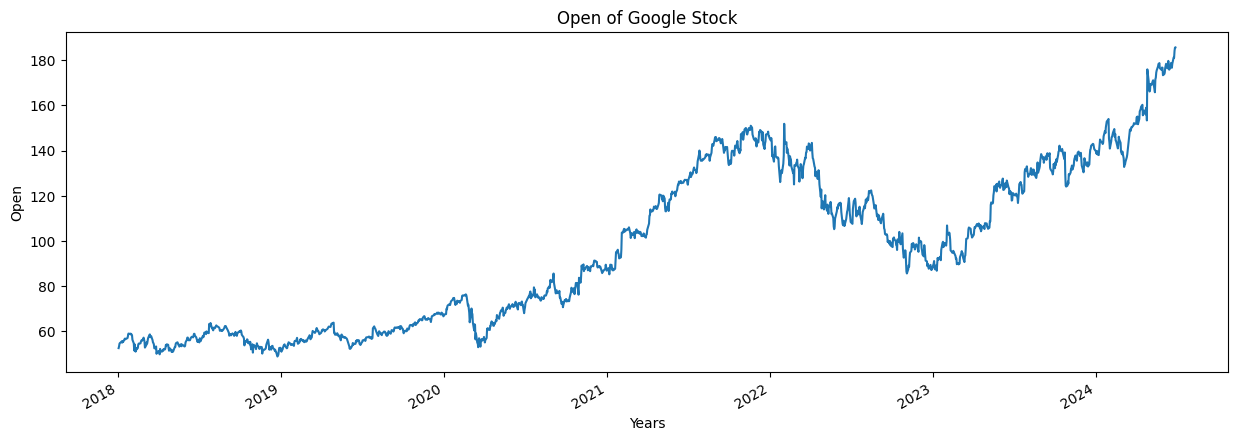

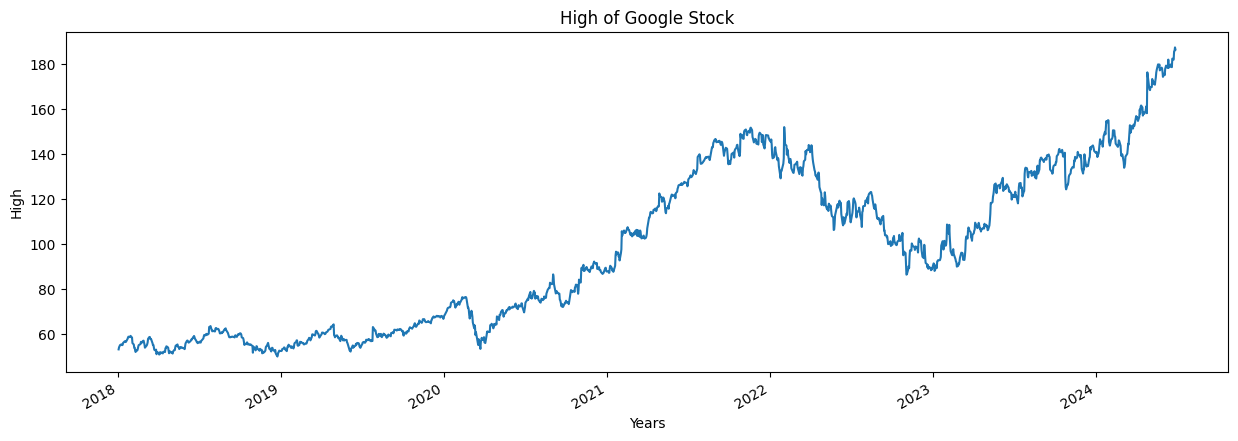

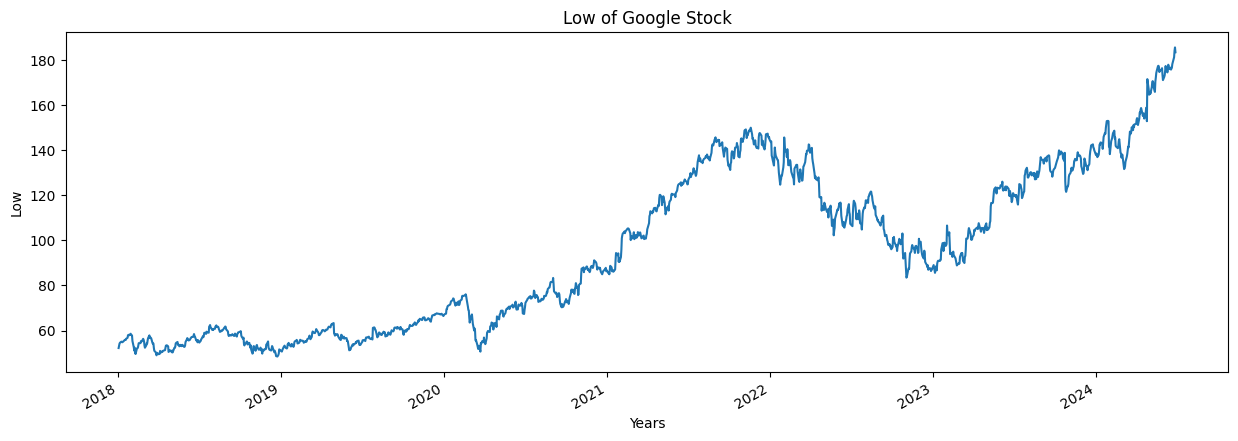

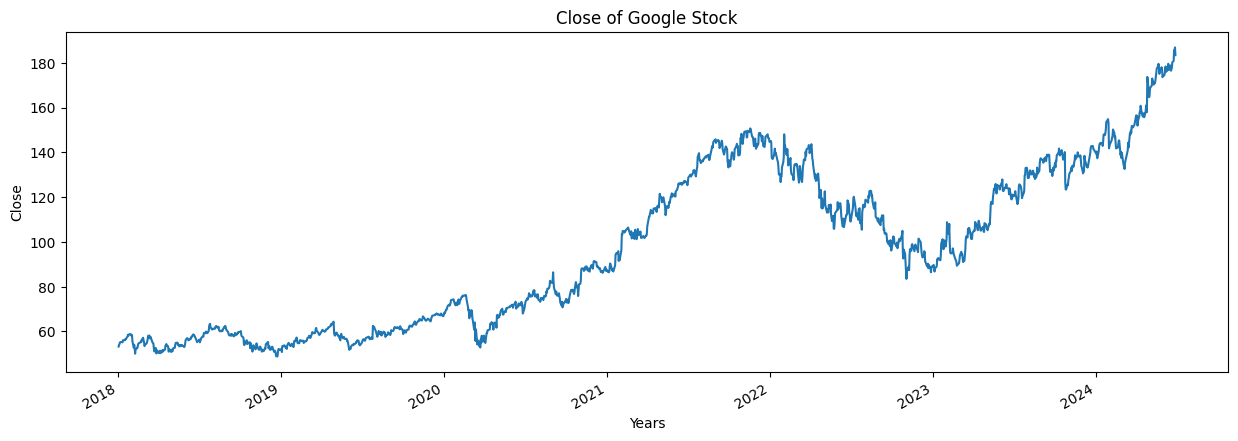

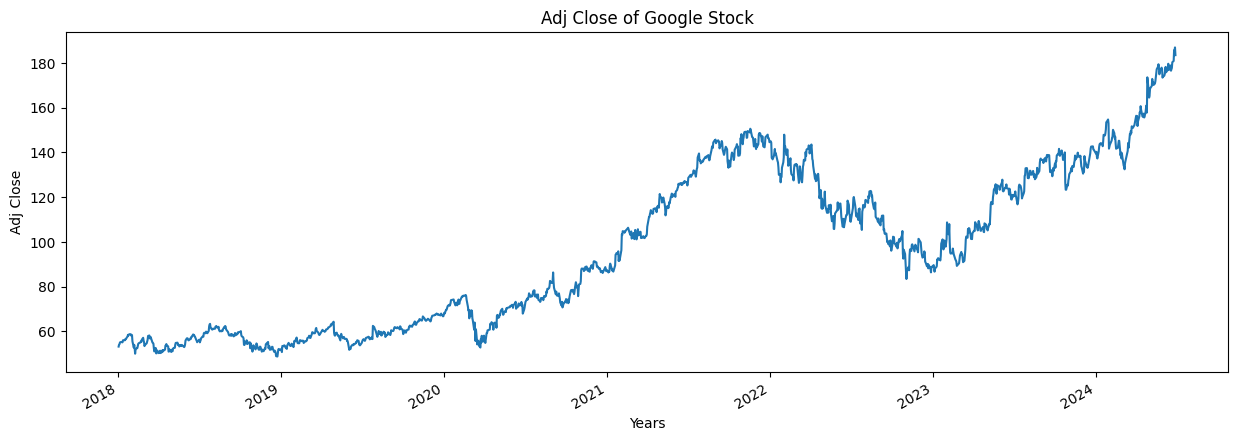

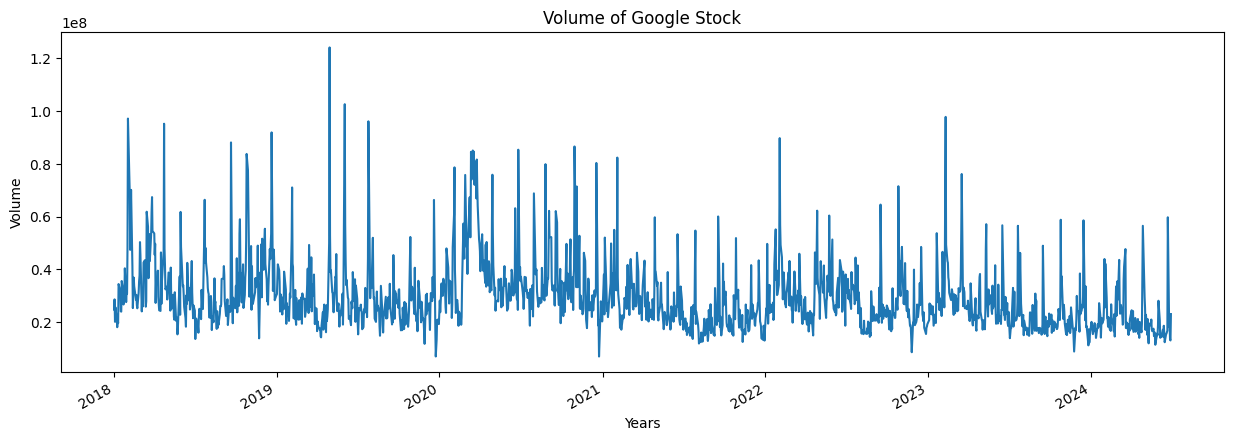

In [8]:
for column in google_stock.columns:
    plot_stock_data((15,5),google_stock[column], column, 'Years')

In [9]:
sentiment = pd.read_csv("date_sentiment.csv")

In [10]:
google_stock = prepare_stock_data(google_stock)
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

# Merge the DataFrames
merged_data = pd.merge(google_stock, sentiment, on='Date', how='left')

# Reorder columns
column_order = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SentimentIndicator']
merged_data = merged_data[column_order]

In [11]:
merged_data = fill_sentiment_gaps(merged_data)

Moving Average technique to determine price of stock

In [12]:
merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,SentimentIndicator
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,53.189472,24752000,3
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,54.062481,28604000,1
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,54.258255,20092000,4
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,55.048855,25582000,1
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,55.284088,20952000,4
...,...,...,...,...,...,...,...,...
1628,2024-06-24,181.279999,182.080002,180.229996,180.789993,180.789993,18198300,2
1629,2024-06-25,181.145004,185.750000,181.104996,185.580002,185.580002,18917700,1
1630,2024-06-26,184.199997,185.929993,183.990005,185.369995,185.369995,13375700,2
1631,2024-06-27,185.645004,187.500000,185.449997,186.860001,186.860001,13025700,2


In [13]:
merged_data['MA_for_250_days'] = merged_data['Adj Close'].rolling(window=250).mean()
merged_data['MA_for_100_days'] = merged_data['Adj Close'].rolling(window=100).mean()
merged_data['MA_for_30_days'] = merged_data['Adj Close'].rolling(window=30).mean()

<Figure size 640x480 with 0 Axes>

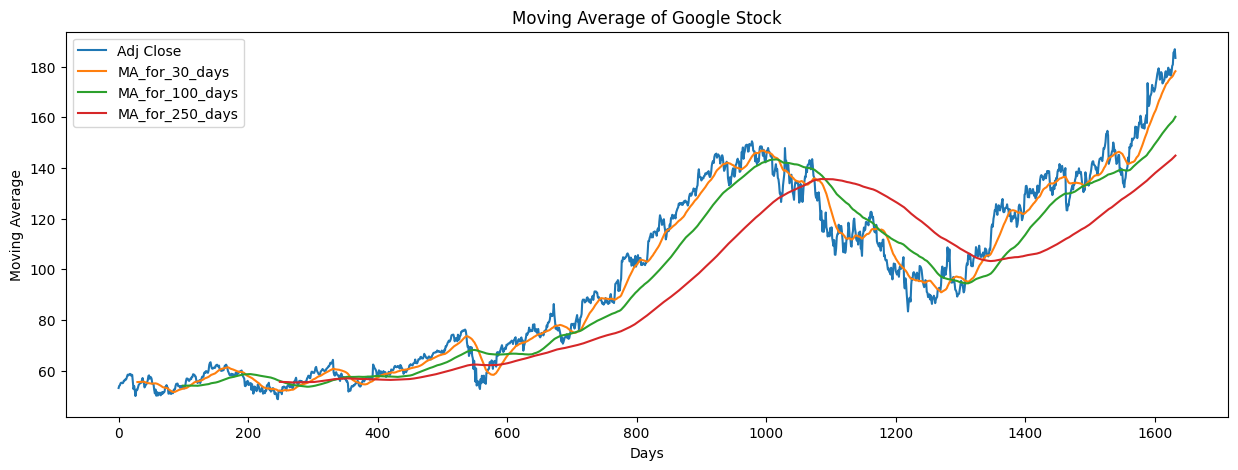

In [14]:
plot_stock_data((15,5),merged_data[['Adj Close','MA_for_30_days','MA_for_100_days','MA_for_250_days']], 'Moving Average', 'Days')

As we can see here more better describe our data is moving average data based on 30 days of trading

In [15]:
merged_data['percent_change'] = merged_data['Adj Close'].pct_change()
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1633 non-null   datetime64[ns]
 1   Open                1633 non-null   float64       
 2   High                1633 non-null   float64       
 3   Low                 1633 non-null   float64       
 4   Close               1633 non-null   float64       
 5   Adj Close           1633 non-null   float64       
 6   Volume              1633 non-null   int64         
 7   SentimentIndicator  1633 non-null   int64         
 8   MA_for_250_days     1384 non-null   float64       
 9   MA_for_100_days     1534 non-null   float64       
 10  MA_for_30_days      1604 non-null   float64       
 11  percent_change      1632 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 153.2 KB


In [16]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
merged_data[['Open', 'High', 'Low', 'Close']] = feature_scaler.fit_transform(merged_data[['Open', 'High', 'Low', 'Close']])

target_scaler = MinMaxScaler(feature_range=(0, 1))
merged_data['Adj Close'] = target_scaler.fit_transform(merged_data[['Adj Close']])

In [17]:
features = ['Open', 'High', 'Low', 'Close', 'SentimentIndicator']
target = 'Adj Close'

In [18]:
sequence_length = 30

X_seq = []
y_seq = []

for i in range(30, len(merged_data)):
    X_seq.append(merged_data[features].values[i-sequence_length:i])
    y_seq.append(merged_data[target].values[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [19]:
splitting_len = int(len(X_seq) * 0.7)

x_train = X_seq[:splitting_len]
y_train = y_seq[:splitting_len]

x_test = X_seq[splitting_len:]
y_test = y_seq[splitting_len:]

In [20]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1122, 30, 5)
(481, 30, 5)
(1122,)
(481,)


In [21]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1122/1122 [==============================] - 16s 11ms/step - loss: 0.0027
Epoch 2/5
1122/1122 [==============================] - 13s 12ms/step - loss: 8.7346e-04
Epoch 3/5
1122/1122 [==============================] - 15s 13ms/step - loss: 7.5828e-04
Epoch 4/5
1122/1122 [==============================] - 13s 11ms/step - loss: 6.7281e-04
Epoch 5/5
1122/1122 [==============================] - 13s 12ms/step - loss: 5.1135e-04


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 119667 (467.45 KB)
Trainable params: 119667 (467.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
predictions = model.predict(x_test)

16/16 [==============================] - 1s 7ms/step


In [26]:
inv_predictions = target_scaler.inverse_transform(predictions)
inv_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
np.sqrt(mean_squared_error(inv_y_test, inv_predictions))

3.0993250621279627

In [28]:
ploting_data = pd.DataFrame(
    {
        'Actual': inv_y_test.flatten(), 
        'Predicted': inv_predictions.flatten()
    },
    index = merged_data.index[1122+30:]
)

merged_data[['Open', 'High', 'Low', 'Close']] = feature_scaler.inverse_transform(merged_data[['Open', 'High', 'Low', 'Close']])
merged_data['Adj Close'] = target_scaler.inverse_transform(merged_data[['Adj Close']])

In [29]:
Adj_close_price = merged_data[['Adj Close']]

In [30]:
ploting_data

,Actual,Predicted
1152,115.348740,115.670540
1153,115.768265,116.779198
1154,118.644989,116.084564
1155,118.734886,118.353821
1156,118.085625,118.674934
...,...,...
1628,180.789993,174.713074
1629,185.580002,177.963608
1630,185.369995,179.869278
1631,186.860001,180.038803


<Figure size 640x480 with 0 Axes>

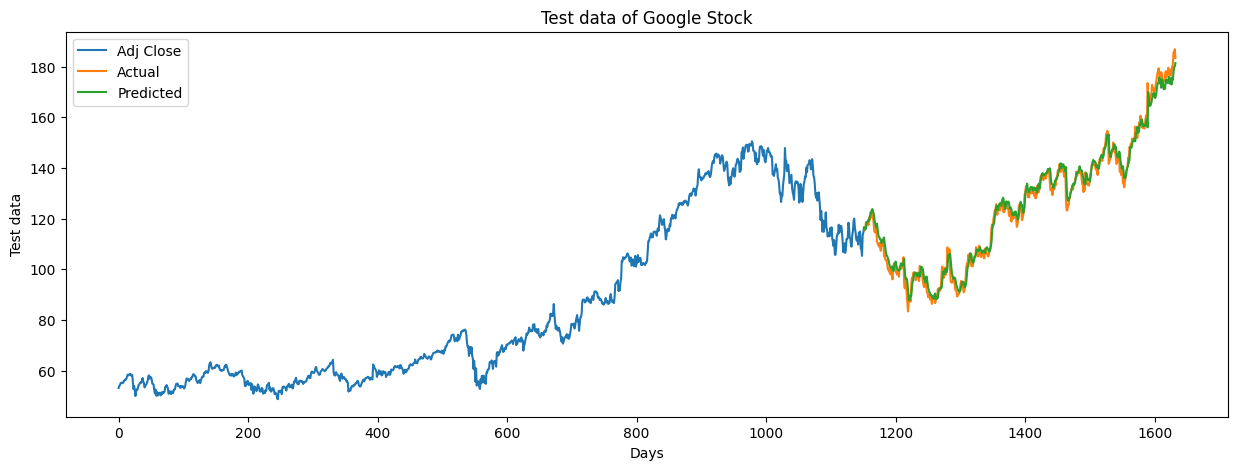

In [33]:
plot_stock_data((15,5),pd.concat([Adj_close_price[:1122+30], ploting_data], axis=0), 'Test data', 'Days')

From plot we can see that our model predicts price really good and rmse of model is around 3%